In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython
import time
from torch.utils.data import Dataset
import random
import torch
import torchaudio
from torch.utils.data import DataLoader
from randomDataset import RandomDataset
import sys
#sys.path.append("..")
from utils.cnn import CNNNetwork
from utils.lstm import LSTMNetwork
from utils import LABELS
from utils.numpyDataset import NumpyDataset
print(LABELS)
#from pydub import AudioSegment

30000
torch.Size([64, 1, 16, 375])
torch.Size([64, 8, 8, 93])
torch.Size([64, 16, 4, 23])
torch.Size([64, 32, 2, 5])
torch.Size([64, 64, 1, 1])
torch.Size([64, 7])
['Amos', 'Kailash', 'Cyprian', 'Selena', 'Aneri', 'Dylan', 'Jennifer']


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
loss = torch.nn.CrossEntropyLoss()

src = 'speeches'
nfft=512
nmels=60
mfcc = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=15, melkwargs={'n_fft':nfft, 'n_mels':nmels})

#dataSet = RandomDataset(src, 16000, 1000, mfcc, 6, 5)

dataSet = NumpyDataset("./trainX.npy", "./trainY.npy")
train_data, val_data = torch.utils.data.random_split(dataSet, (55000, 5001))
input_shape = dataSet[0][0]
train_dl = DataLoader(train_data, batch_size=64)
val_dl = DataLoader(val_data, batch_size=64)

# fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
# for i in range(3):
#     img, label = val_data[i]
#     if i==0:
#         print('shape of feature:', img.shape)
#         print('datatype', img.dtype)
#         input_shape = img.shape
#     axs[i].imshow(img[0].cpu(), origin='lower')
#     axs[i].set_title(f'label: {label}')
print(input_shape)

cuda
[[0.06054688 0.06054688 0.06054688 ... 0.03710938 0.10058594 0.10058594]
 [0.89160156 0.4140625  0.4140625  ... 0.51660156 0.9511719  0.9707031 ]
 [0.7675781  0.7675781  0.7675781  ... 0.51953125 0.8720703  0.9892578 ]
 ...
 [0.43945312 0.79003906 0.828125   ... 0.60058594 0.8027344  0.9355469 ]
 [0.82714844 0.82714844 0.86816406 ... 0.5078125  0.8613281  0.29589844]
 [0.8857422  0.8857422  0.41503906 ... 0.7236328  0.6660156  0.9863281 ]]


In [5]:
model = CNNNetwork(out_neurons=7, input_shape=(1, 16, 375), layers=[16, 32, 64, 128], kernel = (2, 4), stride=(1, 2))
#model = LSTMNetwork(input_dim=16, hidden_dim=32, lstm_layers=1, linear_layers=[16, 7])
model(torch.rand(64, 1, 16, 375))

model = model.to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
loss = torch.nn.CrossEntropyLoss()

90720
torch.Size([64, 1, 16, 375])
torch.Size([64, 16, 9, 94])
torch.Size([64, 32, 6, 24])
torch.Size([64, 64, 4, 6])
torch.Size([64, 128, 3, 2])
CNNNetwork(
  (conv_layer0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 4), stride=(1, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 4), stride=(1, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 4), stride=(1, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 4), stride=(1, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten

In [6]:
def train_epoch(model, train_data_loader, val_data_loader, loss_fn, opt, device, metrics):

    model.train()
    losses = []
    accuracies = []
    for input, target in train_data_loader:
        input, target = input.to(device), target.to(device)

        # calculate loss
        prediction = model(input.unsqueeze(1))
        
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
        # backpropagate error and update weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    metrics['t_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['t_loss'].append((sum(losses)/sum(accuracies)).cpu())
    
    model.eval()
    losses = []
    accuracies = []
    for input, target in val_data_loader:
        input, target = input.to(device), target.to(device)
        prediction = model(input.unsqueeze(1))
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
    
    metrics['v_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['v_loss'].append((sum(losses)/sum(accuracies)).cpu())

In [ ]:
metrics = {
    't_loss': [],
    'v_loss': [],
    't_acc': [],
    'v_acc': []
}
print('****** STARTING TRAINING ******')
for epoch in range(120):
    train_epoch(model, train_dl, val_dl, loss_fn=loss, opt=optimizer, device=device, metrics=metrics)
    print(f"Finished epoch: {epoch} Val loss: {metrics['v_loss'][-1]}, Val acc: {metrics['v_acc'][-1]}")

print("Fininshed training")    
print('best validation accuracy', max(metrics['v_acc']).data)

plt.plot(metrics['t_loss'])
plt.plot(metrics['v_loss'])
plt.legend(['training', 'validation'])
plt.title('cross entropy loss')
plt.show()

plt.figure(1)
plt.plot(metrics['t_acc'])
plt.plot(metrics['v_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')

****** STARTING TRAINING ******
Finished epoch: 0 Val loss: 1.5914814472198486, Val acc: 0.8355969190597534
Finished epoch: 1 Val loss: 1.590976357460022, Val acc: 0.8353990912437439
Finished epoch: 2 Val loss: 1.5881973505020142, Val acc: 0.8363880515098572
Finished epoch: 3 Val loss: 1.5856850147247314, Val acc: 0.8371791839599609
Finished epoch: 4 Val loss: 1.5829921960830688, Val acc: 0.8381680846214294
Finished epoch: 5 Val loss: 1.5809378623962402, Val acc: 0.8387614488601685
Finished epoch: 6 Val loss: 1.5786651372909546, Val acc: 0.8395525813102722
Finished epoch: 7 Val loss: 1.5774219036102295, Val acc: 0.8397504091262817
Finished epoch: 8 Val loss: 1.5727877616882324, Val acc: 0.8417282104492188
Finished epoch: 9 Val loss: 1.5695085525512695, Val acc: 0.8429149389266968
Finished epoch: 10 Val loss: 1.5678004026412964, Val acc: 0.843310534954071
Finished epoch: 11 Val loss: 1.5650410652160645, Val acc: 0.8442994356155396
Finished epoch: 12 Val loss: 1.5615373849868774, Val acc

In [10]:
params = "out_neurons=7, input_shape=(1, 16, 375), layers=[8, 16, 32, 64, 128], kernel = (2, 4), stride=(1, 2))"
torch.save(model.state_dict(), params)

True label was Amos. Prediction was Selena with tensor([1.], device='cuda:0') confidence
True label was Aneri. Prediction was Selena with tensor([1.], device='cuda:0') confidence
True label was Cyprian. Prediction was Selena with tensor([1.], device='cuda:0') confidence
True label was Dylan. Prediction was Selena with tensor([1.], device='cuda:0') confidence
True label was Jennifer. Prediction was Selena with tensor([0.9991], device='cuda:0') confidence
True label was Kailash. Prediction was Selena with tensor([1.], device='cuda:0') confidence
True label was Amos. Prediction was Jennifer with tensor([0.9998], device='cuda:0') confidence
True label was Aneri. Prediction was Cyprian with tensor([0.9855], device='cuda:0') confidence
True label was Cyprian. Prediction was Selena with tensor([1.], device='cuda:0') confidence
True label was Dylan. Prediction was Selena with tensor([1.], device='cuda:0') confidence
True label was Jennifer. Prediction was Selena with tensor([1.], device='cuda:

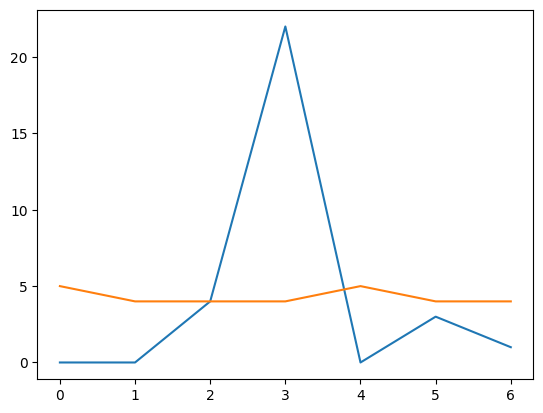

In [9]:
from utils.codec import CodecTransform
codec = CodecTransform(16000, 12.0)
# src = 'speeches'
# src = 'test_data_overheard/'
src = 'test_data_overheard_resampled/'
#src = 'speeches'
#_, sr = torchaudio.load(src + 'overheard_dylan.wav')

#model = LSTMNetwork(input_dim=15, hidden_dim=32, lstm_layers=1, linear_layers=[16, 7])
#model.load_state_dict(torch.load(params))
model.eval()
model = model.to(device)
test = RandomDataset(src, 16000, 30, codec, 6, 5)
testDl = DataLoader(test, batch_size=1)

correct = 0
total = 0
preds_distribution = np.zeros(7)
correct_distribution = np.zeros(7)
for input, target in testDl:
    input, target = input.to(device), target.to(device)
    #print(input.shape)
    #raise
    prediction = model(input)
    confidence, preds = torch.max(prediction.data, 1)

    if preds == target:
        correct += 1
    else:
        pass
        print(f'True label was {LABELS[target]}. Prediction was {LABELS[preds]} with {confidence.data} confidence')
    total += 1
    preds_distribution[preds.data] += 1
    correct_distribution[target.data] += 1

print('accuracy', correct/total)
plt.plot(preds_distribution)
plt.plot(correct_distribution)

In [115]:
# for f in os.listdir(src):
#     wav_filename = f'{f[:-4]}.wav'
#     AudioSegment.from_file(src + f, format = 'm4a').export(src + wav_filename, format = 'wav')

In [52]:
# wav, sr = torchaudio.load(src + 'overheard_dylan.wav')
# sr_new = 16000
# resampler = torchaudio.transforms.Resample(sr, sr_new, dtype = wav.dtype)
# src = 'test_data_overheard/'
# destination = src[:-1] + '_resampled/'
# for f in os.listdir(src):
#     if f[0] == '.':
#         continue
#     wav, _ = torchaudio.load(src + f)
#     resampled = resampler(wav)
#     torchaudio.save(destination + f, resampled, sr_new)

In [17]:
i = 7008
codec.cpu()
codes, label = dataSet[i]
wav = codec.decode(torch.tensor(codes).unsqueeze(0))
print(LABELS[label])
IPython.display.Audio(wav, rate=24000)


Aneri


In [18]:
test = RandomDataset(src, 16000, 1000, lambda x:x, 6, 5)
wav, label = test[180]
print(LABELS[label])
IPython.display.Audio(wav, rate=16000)


Kailash


In [118]:
amos : 0
kailash : 1
cyprian : 2